placeholder

Notes on color pallette:
- qualitative palettes, good for representing categorical data: sns.color_palette("colorblind")
- sequential palettes, good for representing numeric data:  Seaborn includes four perceptually uniform sequential colormaps: "rocket", "mako", "flare", and "crest". sns.color_palette("rocket", as_cmap=True) or discrete sns.color_palette("rocket")
- diverging palettes, good for representing numeric data with a categorical boundary (data where both large low and high values are interesting and span a midpoint value (often 0) that should be de-emphasized) --> 'vlag' or 'icefire' sns.color_palette("vlag", as_cmap=True)

- Apply the default theme
sns.set_theme()
sns.set_style("whitegrid")
sns.color_palette("colorblind")

In [1]:
# Importing required packages and modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
from scipy.stats import spearmanr
import geopandas as gpd
from shapely.geometry import Point
import folium
from IPython.display import IFrame
import webbrowser

In [2]:
# Overview and grouping of the datacolumns for loop later on
numerical_columns = ['Price','price_per_sqm','price_per_sqm_land','Living_area','gardenSurface', 'terraceSurface','Number_of_facades','Number_of_bedrooms']
categorical_columns = ['Subtype','Kitchen_type','State_of_building','epc','Postal_code','Province', 'Assigned_City']
binary_columns = ['Swimming_Pool','Open_fire','Furnished', 'Has_Assigned_City'] # 'hasTerrace', not reliably maintained so leaving it out of analyzing/visualization

**Generating a pandas dataframe from the source .pkl file**

In [3]:
# Set options to show all columns
pd.set_option('display.max_columns', None)

# Load .pkl file and generate pandas dataframe
input_pkl = r'..\data\clean\after_step_4_correlation.pkl' # Fill your path to file
df_1 = pd.read_pickle(input_pkl)

df_1_shape = df_1.shape # Pass the shape of the dataframe to a variable for summary at end of the outlier detection and removal part
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4180 entries, 0 to 5923
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   id                         4180 non-null   Int64   
 1   locality_name              4180 non-null   category
 2   Postal_code                4180 non-null   int64   
 3   Price                      4180 non-null   Int64   
 4   Subtype                    4180 non-null   int64   
 5   Number_of_bedrooms         4180 non-null   Int64   
 6   Living_area                4180 non-null   Int64   
 7   street                     4180 non-null   category
 8   number                     4165 non-null   category
 9   latitude                   4180 non-null   float64 
 10  longitude                  4180 non-null   float64 
 11  Open_fire                  4180 non-null   int64   
 12  Swimming_Pool              4180 non-null   int64   
 13  hasTerrace                 2813 non-nu

**PRICES IN BELGIUM**

Text(0.5, 211.85316792101062, 'Longitude')

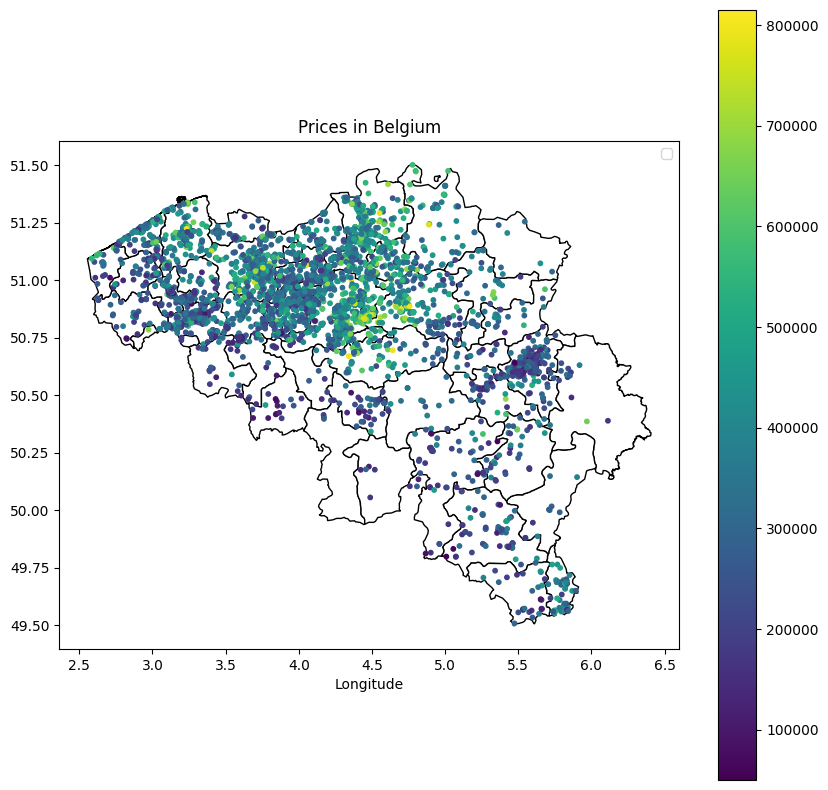

In [4]:
# Load data from a CSV file
df = pd.read_csv(r'..\data\clean\after_step_4_correlation.csv')

# Creating point geometry with Longitude and Latitude
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Setting the reference frame (CRS), e.g. EPSG:4326
gdf.set_crs(epsg=4326, inplace=True)

# Load administrative boundaries (e.g. Belgium)
# Replace 'path/to/belgium_shapefile.shp' with the path to your file
# Downloaded from: https://gadm.org/download_country.html#google_vignette
borders = gpd.read_file(r"C:\Users\izama\Desktop\gadm41_BEL_shp\gadm41_BEL_3.shp")

# Set the frame of reference for the boundaries if different (for example EPSG:4326)
#borders = borders.to_crs(epsg=4326)

# Visualization
fig, ax = plt.subplots(figsize=(10, 10))

# Draw administrative boundaries on the map
borders.plot(ax=ax, color='white', edgecolor='black', linewidth=1) 

# Draw price points (Price)
scatter = gdf.plot(ax=ax, 
                   column='Price', 
                   cmap='viridis',  # Color map
                   legend=True, 
                   markersize=10)

# Add a legend
handles, labels = scatter.get_legend_handles_labels()
ax.legend(handles, [f'{int(float(label))}' for label in labels])

plt.title('Prices in Belgium')
plt.xlabel('Longitude')
##plt.ylabel('Latitude')
#plt.grid()
#plt.show()


**PRICE DISTRIBUTION**

[(0.0, 900000.0)]

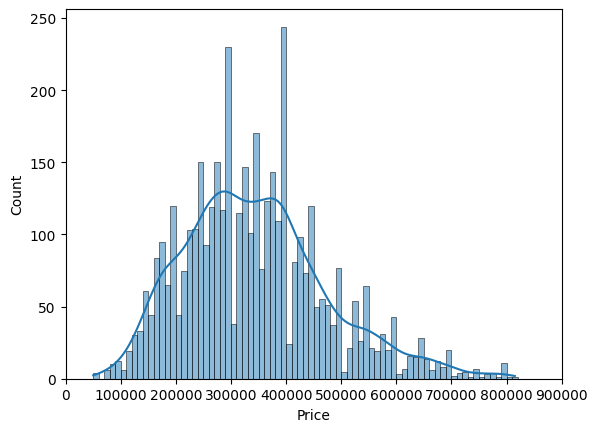

In [5]:
plotx= sns.histplot(df, x= 'Price', kde=True, binwidth=10000, binrange=(0, 900000)
                    )
plotx.set(xlim=(0, 900000))

In [21]:
# Ensure 'Postal_code' is converted to integer for comparison
df['Postal_code'] = df['Postal_code'].astype(int)

# Apply the first condition: Flanders or Wallonie
df['region'] = df['Postal_code'].apply(
    lambda x: 'Flanders' if (1500 <= x < 4000) or (8000 <= x <= 9999) else 'Wallonie'
)

# Update 'region' to 'Brussels' for specific postal codes (compare integers)
df['region'] = df.apply(
    lambda row: 'Brussels' if 1000 <= row['Postal_code'] < 1300 else row['region'], axis=1
)
# Display the first few rows
#df.head()

In [24]:
grouped_counts = df.groupby('region').size()
print(grouped_counts)

region
Wallonie    4180
dtype: int64


[(0.0, 800000.0)]

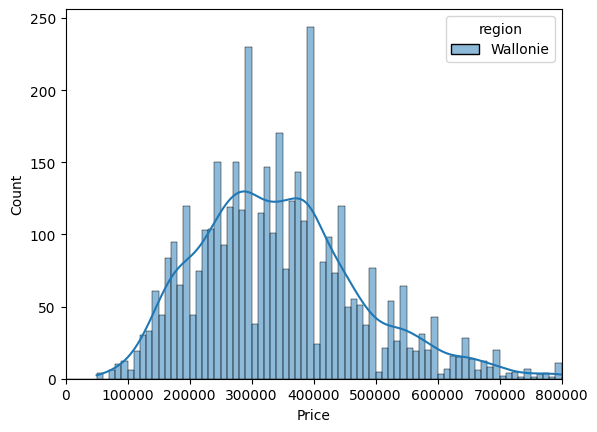

In [20]:
plotx= sns.histplot(df, x= 'Price', kde=True, hue = "region", binwidth=10000, binrange=(0, 1000000))
plotx.set(xlim=(0, 800000))

**CORRELATION MATRIX**

Spearman's Correlation Matrix:
                        Price  price_per_sqm  price_per_sqm_land  Living_area  \
Price               1.000000       0.692438            0.289204     0.490746   
price_per_sqm       0.692438       1.000000            0.298032    -0.228418   
price_per_sqm_land  0.289204       0.298032            1.000000     0.032186   
Living_area         0.490746      -0.228418            0.032186     1.000000   
gardenSurface       0.063016       0.006446           -0.398835     0.083053   
terraceSurface      0.070264      -0.003084           -0.090262     0.101022   
Number_of_facades   0.205601       0.151989           -0.321214     0.109353   
Number_of_bedrooms  0.302215      -0.041702            0.069310     0.475248   
Subtype                  NaN            NaN                 NaN          NaN   
Kitchen_type        0.018608       0.032428            0.015062    -0.019845   
State_of_building   0.218248       0.215677            0.189401     0.049530   
epc     

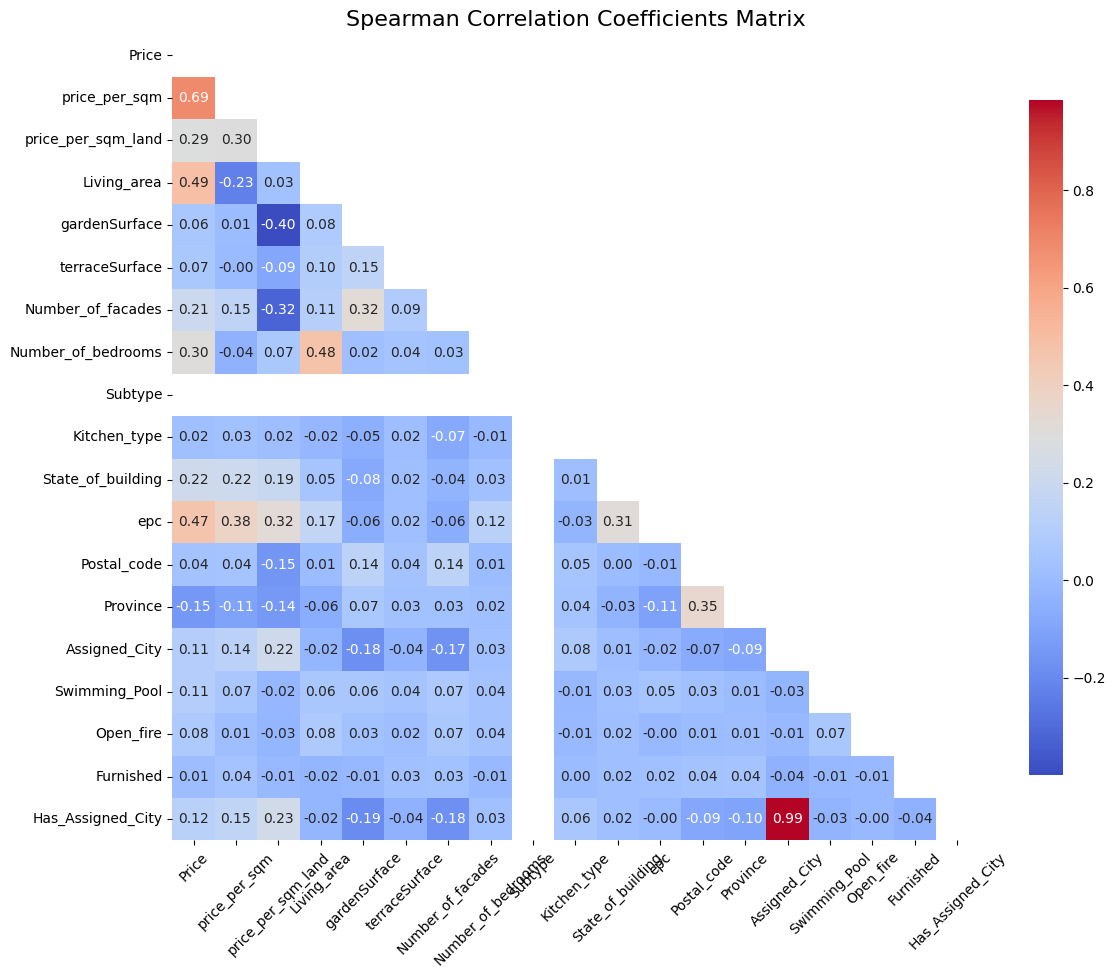

In [7]:
# Step 1: select categorical and binary columns
non_numerical_columns = categorical_columns + binary_columns
all_data_columns = numerical_columns + non_numerical_columns

# Step2: Encode the non-numerical columns to numerical values using pd.factorize and keep the other data columns intact in the dataframe
df_1_encoded = df_1[non_numerical_columns].apply(lambda x: pd.factorize(x)[0]) #code to encode an keep only the altered columns
df_1[non_numerical_columns] = df_1[non_numerical_columns].apply(lambda x: pd.factorize(x)[0]) # code to keep the other data columns intact in the dataframe

# Step 3: Calculate Spearman's correlation coefficient --> choose
#spearman_correlation_matrix = df_1_encoded.corr(method='spearman')
spearman_correlation_matrix = df_1[all_data_columns].corr(method='spearman')

# Step 4: Display the coefficients table
print("Spearman's Correlation Matrix:\n", spearman_correlation_matrix)

# Step 5: Create a heat map matrix
# # Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(spearman_correlation_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(spearman_correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, mask=mask)

# Add title
plt.title('Spearman Correlation Coefficients Matrix', fontsize=16)
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.yticks(rotation=0)   # Y-axis labels horizontal
plt.tight_layout()       # Automatically adjust layout
plt.show()

**EPC**

Text(0.5, 1.0, 'Price Distribution by EPC (normalized)')

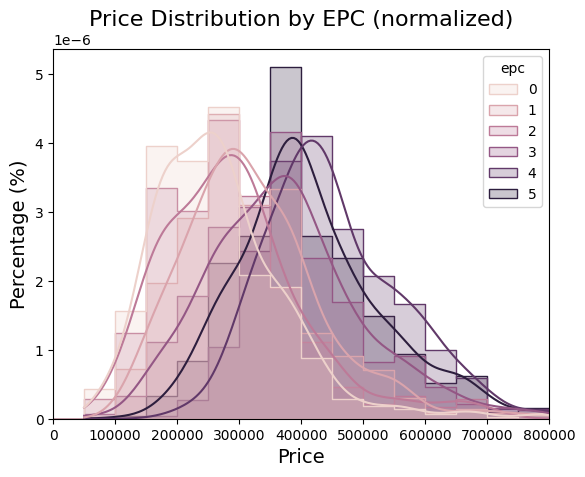

In [8]:
plotx= sns.histplot(df, x= 'Price', kde=True, hue = "epc", binwidth=50000, binrange=(0, 1000000), stat='density', element = "step", common_norm=False)

plotx.set(xlim=(0, 800000))

# Set labels and title
plotx.set_xlabel('Price', fontsize=14)
plotx.set_ylabel('Percentage (%)', fontsize=14)
plotx.set_title('Price Distribution by EPC (normalized)', fontsize=16)

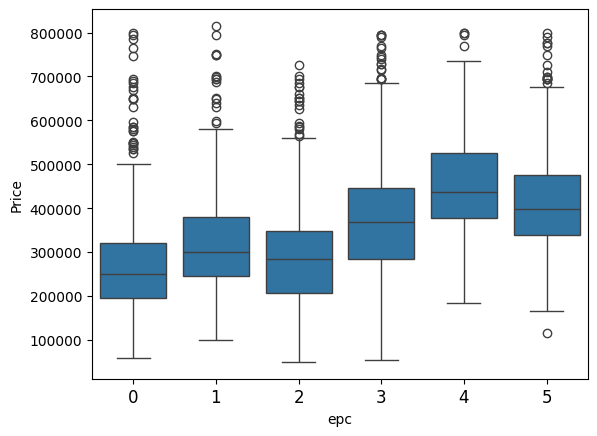

In [9]:
sorted_df2 = df.sort_values(by='epc')

plot = sns.boxplot(x='epc', y='Price', data=sorted_df2,  legend = False)
plt.xticks(fontsize=12)
plt.show()

**STATE OF THE BUILDING**

Text(0.5, 1.0, 'Price Distribution by State of building (normalized)')

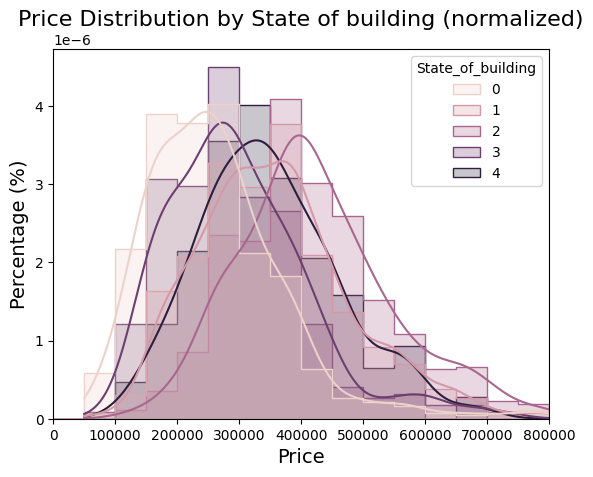

In [10]:
plotx= sns.histplot(df, x= 'Price', kde=True, hue = "State_of_building", binwidth=50000, binrange=(0, 1000000), stat='density', element = "step", common_norm=False)

plotx.set(xlim=(0, 800000))

# Set labels and title
plotx.set_xlabel('Price', fontsize=14)
plotx.set_ylabel('Percentage (%)', fontsize=14)
plotx.set_title('Price Distribution by State of building (normalized)', fontsize=16)

**NUMBER OF BEDROOMS**

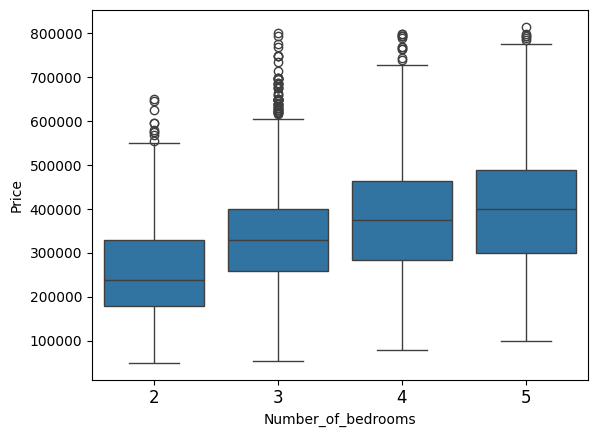

In [11]:
sorted_df3 = df.sort_values(by='Number_of_bedrooms')

plot = sns.boxplot(x='Number_of_bedrooms', y='Price', data=sorted_df3,  legend = False)
plt.xticks(fontsize=12)
plt.show()

**LOCATION**

[(0.0, 800000.0)]

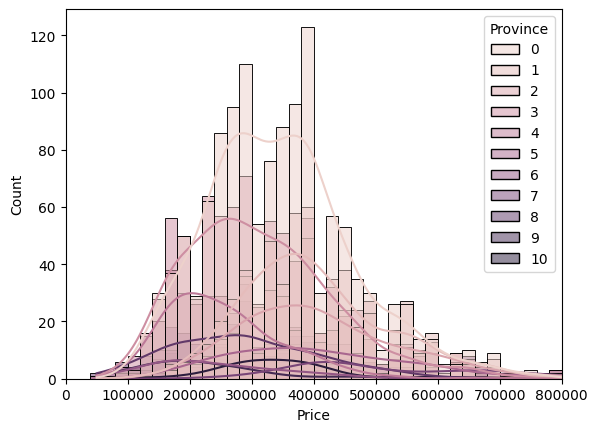

In [12]:
#flanders_df = df[df['region'] == "Flanders"]

plotx= sns.histplot(df, x= 'Price', kde=True, hue = "Province", binwidth=20000, binrange=(0, 1000000), alpha=0.5)
plotx.set(xlim=(0, 800000))



Has_Assigned_City
0    3082
1    1098
Name: count, dtype: int64


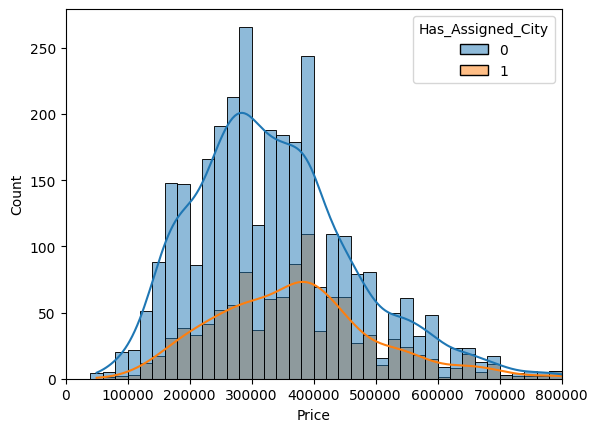

In [13]:
df['Has_Assigned_City'] = df['Has_Assigned_City']
plotx= sns.histplot(df, x= 'Price', kde=True, hue = "Has_Assigned_City", binwidth=20000, binrange=(0, 1000000), alpha=0.5)
plotx.set(xlim=(0, 800000))

print(df['Has_Assigned_City'].value_counts())


**INTERACTIVE MAP**

In [14]:
import folium
import pandas as pd
import branca

# Set options to show all columns
pd.set_option('display.max_columns', None)

# Load CSV file and generate pandas DataFrame
input_csv = r'C:\Users\izama\Desktop\immo-eliza-team6-analysis\immo-eliza-team6-analysis\data\clean\after_step_4_correlation.csv'  # Fill your path to file
df_1 = pd.read_csv(input_csv, sep=',')

# Step 1: Ensure that 'locality_name' is of type str
# Use df_1 instead of df
if 'locality_name' in df_1.columns:
    df_1['locality_name'] = df_1['locality_name'].astype(str)
else:
    print("Column 'locality_name' does not exist in the DataFrame.")

# Step 2: Calculate the average price for each locality name
postal_avg_price = df_1.groupby('locality_name').agg({
    'Price': 'mean',
    'latitude': 'mean',    # Take the average coordinates for each group of locality names
    'longitude': 'mean'
}).reset_index()

# Step 3: Define price ranges and assign colors
def price_color(price):
    if price < 100000:
        return 'green'
    elif price < 200000:
        return 'orange'
    elif price < 300000:
        return 'red'
    else:
        return 'darkred'

# Step 4: Create a map with Folium
m = folium.Map(location=[50.5039, 4.4699], zoom_start=8)  # Centered on Belgium

# Step 5: Adding markers for each locality name with average price information
for i, row in postal_avg_price.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,  # You can adjust the size of the marker based on the average price
        popup=f"City Name: {row['locality_name']}<br>Average Price: €{row['Price']:.2f}",
        color=price_color(row['Price']),  # Use the function to determine the color
        fill=True,
        fill_color=price_color(row['Price']),
        fill_opacity=0.6
    ).add_to(m)

# Step 6: Create a legend
color_scale = branca.colormap.StepColormap(['green', 'orange', 'red', 'darkred'], 
                                             vmin=0, vmax=400000, 
                                             index=[0, 100000, 200000, 300000, 400000], 
                                             caption='Average Price (€)')

# Add the legend to the map
color_scale.add_to(m)

# Step 7: Save the map to an HTML file
#m.save("average_price_by_locality_map.html")

# You can now open the HTML file to see the map
m

